# Preface
"Timbre" is a broad descriptor of the harmonic and time-dependent fluctuations that a sufficiently long duration of audio holds. To the human ear, timbre in the context of primarily music and speech can be wildly subjective as perfectly clean signals only exist in ideal scenarios. An infinite number of timbres may exist as it is dependent on numerous periodic variables present in the time domain. 

Signals containing artifacts and noise due to musical reverberation, acoustic echoes, and scattering present in seismic data among other acoustical phenomena can be analyzed through their spectrograms which represent the frequency content of these signals over time. Machine learning and deep learning methods have been utilized to successfully remove artificially-introduced noise and reverberations through image denoising techniques. However, can timbral and time-sensitive elements of an original signal be recovered and extracted from the subsequent artifacts alone after the signal is no longer present?

This project aims to analyze and predict audio fragments with complex timbres based off the characteristics of their reverberation "tails" rather than the sources themselves. Multiple parameters will be observed and adjusted to find which combination of spectrogram data and prediction algorithm produces the most accurate representation of the original waveform WITHOUT any of the original waveform actually present in the training process (only used for validation purposes). I hope to also draw parallels to various acoustic scattering and inverse problems involving high frequencies which cannot be fully reproduced using traditional numerical approaches by implementing unsupervised deep learning methods.

Individual audio samples from an open-source dataset will be processed through an artificial convolutional reverberation. Then, the original signal will be removed by simply adding the inverted clean waveform to the reverberated audio to leave only the artifacts present. The extent of the original signal in the beginning of each audio example, lasting only a few seconds at most, will then be clipped - this will behave as the testing set. This leaves only artifacts occuring after the input signal has vanished, or the tails, which is the training set for the model. The goal is for the model to pick up on commonalities present in certain frequency banks of each data point (audio input) to strengthen its ability to create an accurate prediction of what audio existed before it rather than to pick up on the convolution algorithm itself, which will be inevitable. 

An image-based method will not be implemented in this experiment; rather, the raw spectrogram data (STFT matrices) will serve as the data which will be further separated into features. Three models will be tested as such:

1.
2.
3.

# Dependencies

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
%matplotlib inline

## Load audio

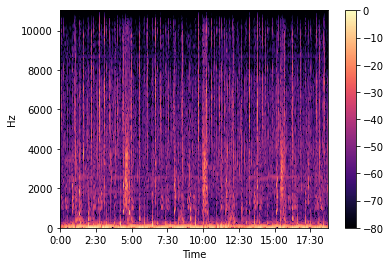

In [242]:
filename = r"C:\Users\Tanay Mannikar\Music\Music Library\death's dynamic shroud.wmv - シェンムーONLINE\death's dynamic shroud.wmv - シェンムーONLINE - 10 鹿威し.flac"
y, sr = librosa.load(filename, sr=22050)
audio = y

ffts = 512
window = 256 # smaller = better temporal resolution, larger = better frequency resolution (time-frequency localization trade-off)
hop = 32 # smaller hop length means more columns
audio_stft = np.abs(librosa.stft(audio, n_fft=ffts, win_length=window, hop_length=hop))
spect_db = librosa.amplitude_to_db(audio_stft, ref=np.max)
plt.figure()
librosa.display.specshow(spect_db, x_axis='time', y_axis='linear')
plt.colorbar()

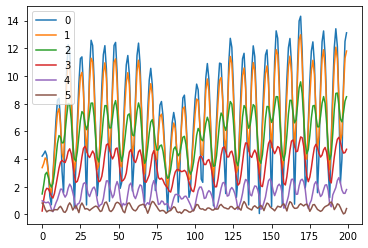

There are 257 FFTs and 48389 frames in this audio sample.


In [243]:
# Checking the data
df = pd.DataFrame(data=audio_stft)
df = df.T
df.iloc[:200, :6].plot() # plot shows change in amplitude of each FFT over "time" with each line representing a different FFT
plt.show()
df.shape
print("There are" , len(df.columns), "FFTs and", len(df.index), "frames in this audio sample.")

## Observations
The spectrogram image represents FFTs as the vertical axis and frames as the horizontal axis. Each horizontal layer in the discretized spectrogram image is represented as a row vector in the STFT matrix. As such, feature extraction is performed by taking individual row vectors as the features in our desired model. The initial FFTs in lower frequencies give us the most information about the fundamental harmonic and larger artifacts in the audio.

## Data preprocessing
I initially normalized the values in each column to have a value between -1 and 1, but this significantly reduces the accuracy of the model because it fails to pick up on dynamic qualities and the fact that all amplitude values are positive. For this reason, it is not necessary to scale the values.

## Grid search method

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=10)
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}

gridsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gridsearch.fit(xtrain, ytrain)
ypred2 = gridsearch.predict(xtest)

result = pd.DataFrame(data=ypred2)
result.plot()

## Walk-forward linear regression model

In [244]:
nbanks = len(df.columns)
nframes = len(df.index)
ntrain = 4
split = 0.5
train_length = int(nframes*split)
array_pred = np.zeros((nframes - train_length, 0))
print(len(array_pred))

24195


In [245]:
from sklearn import linear_model

for i in range(0, nbanks):
    xtrain = df.iloc[:train_length, i:i+ntrain]
    xtest = df.iloc[train_length:, i:i+ntrain]
    ytrain = df.iloc[:train_length, i]
    ytest = df.iloc[train_length:, i]
    
    lr = linear_model.LinearRegression()
    lr.fit(xtrain, ytrain)
    ypred = lr.predict(xtest)
    array_pred = np.c_[array_pred, ypred]
array_pred = array_pred + 0.000001 # ensures all amplitudes are non-zero
print(df.shape, array_pred.shape)

(48389, 257) (24195, 257)


In [246]:
audio_pred = librosa.griffinlim(np.abs(array_pred.T))
audio_scaled = librosa.effects.time_stretch(audio_pred, 4)

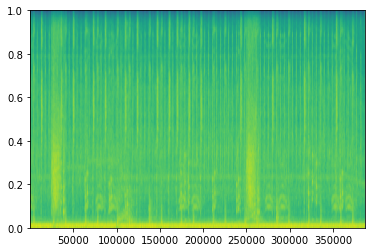

In [247]:
plt.specgram(audio_scaled)
plt.show()

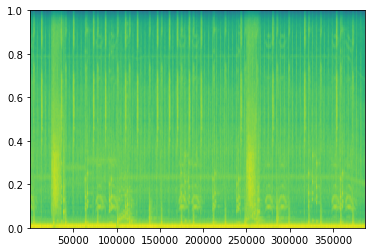

In [248]:
audio_test = audio[int(len(audio)*split):]
plt.specgram(audio_test)
plt.show()

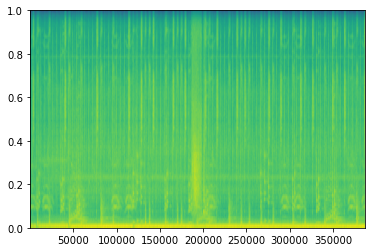

In [249]:
audio_train = audio[:int(len(audio)*split)]
plt.specgram(audio_train)
plt.show()

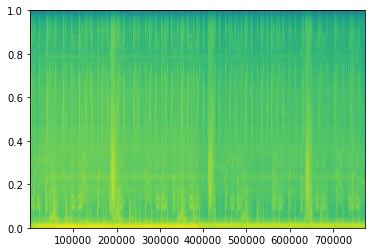

1548416 1548416


In [250]:
audio_full = np.concatenate((audio_train, audio_scaled), axis=None)
plt.specgram(audio_full)
plt.show()
print(len(audio_full), len(audio))

In [251]:
outfile = r'C:\Users\Tanay Mannikar\Documents\Inverberator\audio\inverb_test1.wav'
sf.write(outfile, audio_full, sr, 'PCM_16')

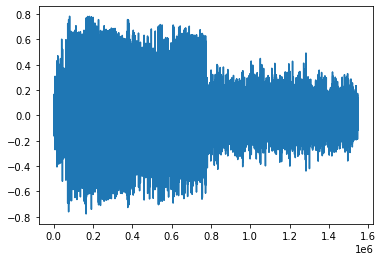

In [252]:
plt.plot(audio_full)